## Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.utils.np_utils import to_categorical
import time

Using TensorFlow backend.


## Don't change these functions

In [2]:
def loadData(filename):
    rawData = pd.read_csv(filename)
    closePrice = np.array(rawData.loc[:, [' CLOSE']])
    return   closePrice[:,0]

def create_dataset(closePrice,look_back,f_horizon):    
    dataX = []
    dataY = []
    dataL=[]
    for i in range(0,len(closePrice)-look_back-f_horizon,1):
        a = closePrice[i:i+look_back]
        b = closePrice[i+look_back:i+look_back + f_horizon]
        dataX.append(a.tolist())
        dataY.append(b.tolist())
    return dataX, dataY

def create_dataset_discrete(closePrice,look_back):    
    dataX = []
    dataY = []
    dataY_raw = []
        
    for i in range(0,len(closePrice)-look_back-1):
        a = closePrice[i:i+look_back]
        end=closePrice[i+look_back-1]
        b = (closePrice[i+look_back] -end)/ (end) * 100
        labels = 0
        if b > 0.25:
            labels = 1
        elif b < -0.25:
            labels = 2
        dataX.append(a.tolist())
        dataY.append(labels)
        dataY_raw.append(b)
        
    return dataX, dataY, dataY_raw

## Min-Max Scaling

In [3]:
def normalize_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(data)
    norm_data=min_max_scaler.transform(data)
    return norm_data,min_max_scaler

## Exponential Moving Average

In [4]:
def exp_moving_avg(data):
    ema = 0.0
    gamma = 0.1
    for ti in range(len(data)):
        ema = gamma*data[ti] + (1-gamma)*ema
        data[ti] = ema
    return data

## Plot Visualization

In [19]:
def visualize(data):
    plt.plot(data)
    plt.show()
    
def hist_visualize(dataY, x_label_name,y_label_name, figure_title):
    n, bins, patches = plt.hist(x=dataY, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(figure_title)
    plt.text(23, 45, r'$\mu=15, b=3$')
    plt.ylim()
    return plt.show()

## Train-Test Split

In [6]:
def train_test_split(dataX,dataY,percent_split):
    row = int(percent_split * dataX.shape[0])
    trainX = dataX[:row, :]
    testX=dataX[row:,:]
    trainY=dataY[:row,:]
    testY=dataY[row:,:]
    return trainX,trainY,testX,testY

## Main Code Here

In [7]:
filename = '../input/stock_data.txt' 
look_back = 8  
percent_train_data = .7 

closePrice= loadData(filename)
norm_closePrice,scaler=normalize_data(np.array(closePrice).reshape(-1,1))
ema=exp_moving_avg(norm_closePrice)
dataX,dataY,dataYraw=create_dataset_discrete(ema,look_back)

## Reshaping

In [8]:
X=np.array(dataX).reshape(-1,1,look_back)
Y_dat=[]
for i in range(len(dataY)):
    Y_dat.append(to_categorical(dataY[i],3).reshape(1,3))
Y=np.array(Y_dat)

In [9]:
print(X.shape)
print(Y.shape)

(7060, 1, 8)
(7060, 1, 3)


In [10]:
X_train,Y_train,X_test,Y_test=train_test_split(X,Y,0.9)
print(X_train.shape)
print(Y_train.shape)

(6354, 1, 8)
(6354, 1, 3)


## Bi-Directional LSTM

In [11]:
def model(look_back, mode):
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(1, look_back), merge_mode=mode))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [20]:
def train_model(model):
    hist=model.fit(X_train,Y_train,batch_size=64,nb_epoch=250)
    return hist

## Comparing Modes

In [13]:
bi_sum=model(look_back,'sum')
sum_hist=train_model(bi_sum)
bi_mul=model(look_back, 'mul')
mul_hist=train_model(bi_mul)
bi_ave=model(look_back,'ave')
ave_hist=train_model(bi_ave)
bi_concat=model(look_back,'concat')
con_hist=train_model(bi_concat)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/250
6354/6354 [==============================] - 5s 731us/step - loss: 1.0657 - acc: 0.4045
Epoch 2/250
6354/6354 [==============================] - 1s 184us/step - loss: 1.0490 - acc: 0.4564
Epoch 3/250
6354/6354 [==============================] - 1s 183us/step - loss: 1.0432 - acc: 0.4555
Epoch 4/250
6354/6354 [==============================] - 1s 179us/step - loss: 1.0413 - acc: 0.4602
Epoch 5/250
6354/6354 [==============================] - 1s 178us/step - loss: 1.0404 - acc: 0.4562
Epoch 6/250
6354/6354 [==============================] - 1s 179us/step - loss: 1.0396 - acc: 0.4572
Epoch 7/250
6354/6354 [==============================] - 1s 180us/step - loss: 1.0398 - acc: 0.4551
Epoch 8/250
6354/6354 [==============================] - 1s 177us/step - loss: 1.0385 - acc: 0.4567
Epoch 9/250
6354/6354 [==============================] - 1s 180us/step - loss: 1.0380 - acc: 0.4600
Epoch 10/250
6354/6354 [==============================] - 1s 178us/step - loss: 1.0384 - acc: 0.4630

6354/6354 [==============================] - 1s 180us/step - loss: 0.7548 - acc: 0.6675
Epoch 163/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.7549 - acc: 0.6736
Epoch 164/250
6354/6354 [==============================] - 1s 181us/step - loss: 0.7506 - acc: 0.6715
Epoch 165/250
6354/6354 [==============================] - 1s 181us/step - loss: 0.7544 - acc: 0.6664
Epoch 166/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.7500 - acc: 0.6717
Epoch 167/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.7516 - acc: 0.6703
Epoch 168/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.7532 - acc: 0.6722
Epoch 169/250
6354/6354 [==============================] - 1s 179us/step - loss: 0.7491 - acc: 0.6726
Epoch 170/250
6354/6354 [==============================] - 1s 177us/step - loss: 0.7484 - acc: 0.6711
Epoch 171/250
6354/6354 [==============================] - 1s 178us/step - loss: 0.7528 - acc: 0

6354/6354 [==============================] - 1s 180us/step - loss: 1.0185 - acc: 0.4969
Epoch 74/250
6354/6354 [==============================] - 1s 181us/step - loss: 1.0173 - acc: 0.4863
Epoch 75/250
6354/6354 [==============================] - 1s 181us/step - loss: 1.0166 - acc: 0.5055
Epoch 76/250
6354/6354 [==============================] - 1s 179us/step - loss: 1.0156 - acc: 0.5197
Epoch 77/250
6354/6354 [==============================] - 1s 182us/step - loss: 1.0147 - acc: 0.5172
Epoch 78/250
6354/6354 [==============================] - 1s 180us/step - loss: 1.0133 - acc: 0.5212
Epoch 79/250
6354/6354 [==============================] - 1s 184us/step - loss: 1.0124 - acc: 0.5331
Epoch 80/250
6354/6354 [==============================] - 1s 184us/step - loss: 1.0112 - acc: 0.5334
Epoch 81/250
6354/6354 [==============================] - 1s 181us/step - loss: 1.0097 - acc: 0.5324
Epoch 82/250
6354/6354 [==============================] - 1s 180us/step - loss: 1.0086 - acc: 0.5466
Epo

6354/6354 [==============================] - 1s 183us/step - loss: 0.7625 - acc: 0.6719
Epoch 234/250
6354/6354 [==============================] - 1s 181us/step - loss: 0.7617 - acc: 0.6662
Epoch 235/250
6354/6354 [==============================] - 1s 178us/step - loss: 0.7608 - acc: 0.6698
Epoch 236/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.7654 - acc: 0.6667
Epoch 237/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.7606 - acc: 0.6731
Epoch 238/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7604 - acc: 0.6701
Epoch 239/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.7588 - acc: 0.6687
Epoch 240/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.7581 - acc: 0.6711
Epoch 241/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.7575 - acc: 0.6692
Epoch 242/250
6354/6354 [==============================] - 1s 181us/step - loss: 0.7574 - acc: 0

6354/6354 [==============================] - 1s 179us/step - loss: 0.8103 - acc: 0.6506
Epoch 145/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.8081 - acc: 0.6590
Epoch 146/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.8093 - acc: 0.6519
Epoch 147/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.8081 - acc: 0.6547
Epoch 148/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.8061 - acc: 0.6536
Epoch 149/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.8032 - acc: 0.6561
Epoch 150/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.8024 - acc: 0.6506
Epoch 151/250
6354/6354 [==============================] - 1s 179us/step - loss: 0.8008 - acc: 0.6579
Epoch 152/250
6354/6354 [==============================] - 1s 178us/step - loss: 0.8006 - acc: 0.6523
Epoch 153/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.8001 - acc: 0

6354/6354 [==============================] - 1s 185us/step - loss: 0.9657 - acc: 0.5891
Epoch 56/250
6354/6354 [==============================] - 1s 180us/step - loss: 0.9623 - acc: 0.5825
Epoch 57/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.9590 - acc: 0.5859
Epoch 58/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.9577 - acc: 0.5921
Epoch 59/250
6354/6354 [==============================] - 1s 184us/step - loss: 0.9524 - acc: 0.5941
Epoch 60/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.9498 - acc: 0.5870
Epoch 61/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.9474 - acc: 0.5927
Epoch 62/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.9431 - acc: 0.5955
Epoch 63/250
6354/6354 [==============================] - 1s 184us/step - loss: 0.9395 - acc: 0.5952
Epoch 64/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.9366 - acc: 0.5958
Epo

6354/6354 [==============================] - 1s 183us/step - loss: 0.7413 - acc: 0.6745
Epoch 216/250
6354/6354 [==============================] - 1s 184us/step - loss: 0.7436 - acc: 0.6744
Epoch 217/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7450 - acc: 0.6728
Epoch 218/250
6354/6354 [==============================] - 1s 182us/step - loss: 0.7396 - acc: 0.6807
Epoch 219/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7437 - acc: 0.6720
Epoch 220/250
6354/6354 [==============================] - 1s 186us/step - loss: 0.7410 - acc: 0.6789
Epoch 221/250
6354/6354 [==============================] - 1s 185us/step - loss: 0.7445 - acc: 0.6686
Epoch 222/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7437 - acc: 0.6764
Epoch 223/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7400 - acc: 0.6805
Epoch 224/250
6354/6354 [==============================] - 1s 183us/step - loss: 0.7417 - acc: 0

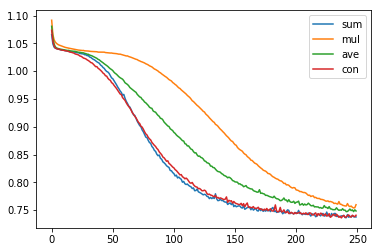

In [14]:
results=pd.DataFrame()
results['sum']=sum_hist.history['loss']
results['mul']=mul_hist.history['loss']
results['ave']=ave_hist.history['loss']
results['con']=con_hist.history['loss']
results.plot()
plt.show()

## Finalizing the Mode

In [15]:
model=model(look_back,'sum')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 20)             4640      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 3)              63        
Total params: 4,703
Trainable params: 4,703
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/1000
6354/6354 [==============================] - 3s 491us/step - loss: 1.0795 - acc: 0.3653
Epoch 2/1000
6354/6354 [==============================] - 1s 185us/step - loss: 1.0567 - acc: 0.4300
Epoch 3/1000
6354/6354 [==============================] - 1s 184us/step - loss: 1.0456 - acc: 0.4578
Epoch 4/1000
6354/6354 [==============================] - 1s 182us/step - loss: 1.0416 - acc: 0.4597
Epoch 5/1000
6354/6354 [==============================] - 1s 183us/step - loss: 1.0405 - acc: 0.4592
Epoch 6/1000
6354/6354 [==============================] - 1s 182us/step - loss: 1.0399 - acc: 0.4572
Epoch 7/1000
6354/6354 [==============================] - 1s 183us/step - loss: 1.0397 - acc: 0.4553
Epoch 8/1000
6354/6354 [==============================] - 1s 184us/step - loss: 1.0388 - acc: 0.4602
Epoch 9/1000
6354/6354 [==============================] - 1s 186us/step - loss: 1.0379 - acc: 0.4585
Epoch 10/1000
6354/6354 [==============================] - 1s 188us/step - loss: 1.0374 - a

6354/6354 [==============================] - 1s 182us/step - loss: 0.7574 - acc: 0.6701
Epoch 161/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7548 - acc: 0.6700
Epoch 162/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7541 - acc: 0.6701
Epoch 163/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.7576 - acc: 0.6695
Epoch 164/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7538 - acc: 0.6736
Epoch 165/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7529 - acc: 0.6741
Epoch 166/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7542 - acc: 0.6704
Epoch 167/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7528 - acc: 0.6697
Epoch 168/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.7518 - acc: 0.6731
Epoch 169/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7501

6354/6354 [==============================] - 1s 189us/step - loss: 0.7300 - acc: 0.6788
Epoch 319/1000
6354/6354 [==============================] - 1s 180us/step - loss: 0.7305 - acc: 0.6829
Epoch 320/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7327 - acc: 0.6782
Epoch 321/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.7289 - acc: 0.6829
Epoch 322/1000
6354/6354 [==============================] - 1s 180us/step - loss: 0.7356 - acc: 0.6744
Epoch 323/1000
6354/6354 [==============================] - 1s 180us/step - loss: 0.7325 - acc: 0.6813
Epoch 324/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7298 - acc: 0.6822
Epoch 325/1000
6354/6354 [==============================] - 1s 185us/step - loss: 0.7287 - acc: 0.6832
Epoch 326/1000
6354/6354 [==============================] - 1s 189us/step - loss: 0.7290 - acc: 0.6827
Epoch 327/1000
6354/6354 [==============================] - 1s 186us/step - loss: 0.7313

6354/6354 [==============================] - 1s 182us/step - loss: 0.7208 - acc: 0.6826
Epoch 477/1000
6354/6354 [==============================] - 1s 178us/step - loss: 0.7165 - acc: 0.6876
Epoch 478/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7194 - acc: 0.6878
Epoch 479/1000
6354/6354 [==============================] - 1s 180us/step - loss: 0.7190 - acc: 0.6873
Epoch 480/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7219 - acc: 0.6833
Epoch 481/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.7169 - acc: 0.6887
Epoch 482/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7179 - acc: 0.6900
Epoch 483/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7190 - acc: 0.6878
Epoch 484/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7192 - acc: 0.6856
Epoch 485/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7191

6354/6354 [==============================] - 1s 188us/step - loss: 0.7049 - acc: 0.6953
Epoch 635/1000
6354/6354 [==============================] - 1s 190us/step - loss: 0.7079 - acc: 0.6922
Epoch 636/1000
6354/6354 [==============================] - 1s 187us/step - loss: 0.7048 - acc: 0.6929
Epoch 637/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.7107 - acc: 0.6867
Epoch 638/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7028 - acc: 0.6952
Epoch 639/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.7028 - acc: 0.6956
Epoch 640/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7074 - acc: 0.6907
Epoch 641/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7061 - acc: 0.6901
Epoch 642/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.7046 - acc: 0.6925
Epoch 643/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.7048

6354/6354 [==============================] - 1s 182us/step - loss: 0.6951 - acc: 0.7007
Epoch 793/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6947 - acc: 0.6972
Epoch 794/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6924 - acc: 0.7025
Epoch 795/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.6924 - acc: 0.6983
Epoch 796/1000
6354/6354 [==============================] - 1s 179us/step - loss: 0.6927 - acc: 0.6989
Epoch 797/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6970 - acc: 0.6972
Epoch 798/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6946 - acc: 0.6953
Epoch 799/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6982 - acc: 0.6959
Epoch 800/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6973 - acc: 0.7038
Epoch 801/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6934

6354/6354 [==============================] - 1s 182us/step - loss: 0.6816 - acc: 0.7043
Epoch 951/1000
6354/6354 [==============================] - 1s 184us/step - loss: 0.6812 - acc: 0.7052
Epoch 952/1000
6354/6354 [==============================] - 1s 180us/step - loss: 0.6814 - acc: 0.7068
Epoch 953/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6805 - acc: 0.7060
Epoch 954/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.6808 - acc: 0.7022
Epoch 955/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6807 - acc: 0.7063
Epoch 956/1000
6354/6354 [==============================] - 1s 182us/step - loss: 0.6802 - acc: 0.7068
Epoch 957/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6810 - acc: 0.7063
Epoch 958/1000
6354/6354 [==============================] - 1s 183us/step - loss: 0.6796 - acc: 0.7125
Epoch 959/1000
6354/6354 [==============================] - 1s 181us/step - loss: 0.6817

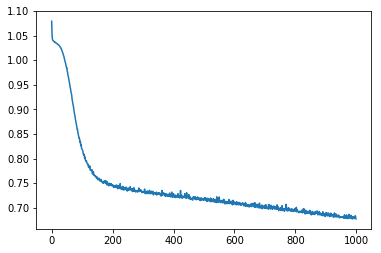

In [16]:
vals=model.fit(X_train,Y_train,batch_size=64,nb_epoch=1000)

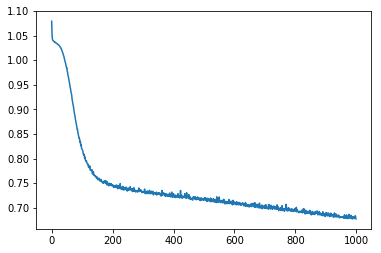

In [21]:
visualize(vals.history['loss'])

## Predictions and Results

In [17]:
preds=model.predict_classes(X_test)
orig=np.array(dataY[6354:]).reshape(-1,1)
accuracy=(preds==orig).sum()/preds.shape[0]
print(accuracy)

0.7407932011331445


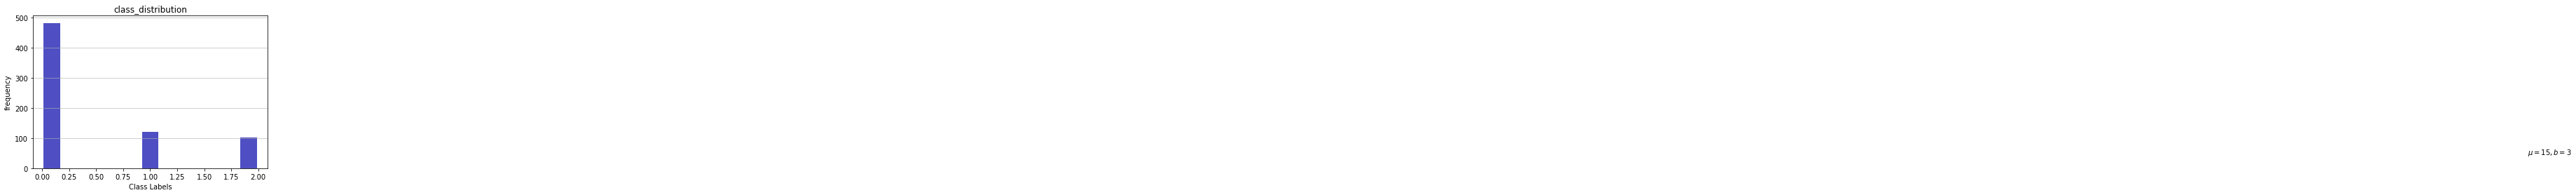

In [18]:
hist_visualize(orig, 'Class Labels','frequency', 'class_distribution')